In [578]:
import math
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import contextily as ctx

import geopy
import shapely
import numpy as np
import geopandas as gpd
from geopy import distance

from cpp_algorithms import imshow
import rasterio.features
import fiona

In [488]:
# Created shapfies have these valeus in the type column
FEATURES = ["coverage", "obstacle", "fuel", "drone"]

def read_shapefile(path, to_del=False):
    """
    Path of the zip file containing the .shp
    """
    path = Path(path)
    ZipFile(path).extractall(path.parent)
    shp_all = []
    for shfile in (path.parent/"layers").iterdir():
        if shfile.suffix == ".shp":
            shp_all.append(gpd.read_file(shfile))
    if to_del:
        (path.parent/"layers").unlink()
    return shp_all

def get_features_dict(shape_files, key='type', fnames=FEATURES):
    """
    Name of the features should be shapefile 
    `key` column values
    """
    features = {}
    for name in fnames:
        features[name] = []
        
    for sh in shape_files:
        for rows in sh.iterrows():
            for k in features:
                if rows[1][key].find(k) >= 0:
                    features[k].append(rows[1].geometry)
    return features

def get_final_coverage_polygon(features):
    """
    Union of coverage and difference of
    obstacles.
    """
    final = features['coverage'][0]
    for cov in features['coverage']:
        final = final.union(cov)
    for obs in features['obstacle']:
        final = final.difference(obs)
    return final

def get_bounding_points(final_coverage):
    """
    lower left, top left, top right, lower right
    """
    llng, llat, rlng, rlat =  final_coverage.bounds
    ll = (llat,llng)
    tl = (rlat,llng)
    tr = (rlat,rlng)
    lr = (llat,rlng)
    return {
        'll':ll,
        'tl':tl,
        'tr':tr,
        'lr':lr
    }

def get_bounding_poly(final_coverage):
    """
    shapely polygon that bound the `final_coverage`
    polygon of the coverage area.
    """
    return final_coverage.envelope

def get_hv_wh(final_coverage):
    """
    Get haversine calcualted width and height of
    the smallest bounding rectangle of final_coverage.
    """
    llng, llat, rlng, rlat =  final_coverage.bounds
    ll = (llat,llng)
    lr = (llat,rlng)
    tr = (rlat,rlng)
    tl = (rlat,llng)
    w = distance.distance(ll,lr)
    h = distance.distance(ll,tl)
    return w, h

def grid_size(side, final_coverage, returnwh=False):
    """
    side : cell side in meters
    final_coverage : area of coverage polygon
    returnwh : True – returns the haversine 
        w,h of the bounding box 
    """
    w, h = get_hv_wh(final_coverage)
    w_count = math.ceil(w.m/side)
    h_count = math.ceil(h.m/side)
    if returnwh:
        return w_count, h_count, w, h
    return w_count, h_count

def create_gdframe(features):
    """
    Create GeoDataFrame from features
    """
    final_coverage = get_final_coverage_polygon(features)
    points = []
    for d in features['drone']:
        points.append({
            'type':'drone',
            'geometry':d
        })
    for f in features['fuel']:
        points.append({
            'type':'fuel',
            'geometry':d
        })
    points.append({
        'type':'coverage',
        'geometry':final_coverage})
    return gpd.GeoDataFrame(points,crs="EPSG:3857")

(72.78930759429932, 72.85180950164795, 18.91483027045598, 19.030543097510375)

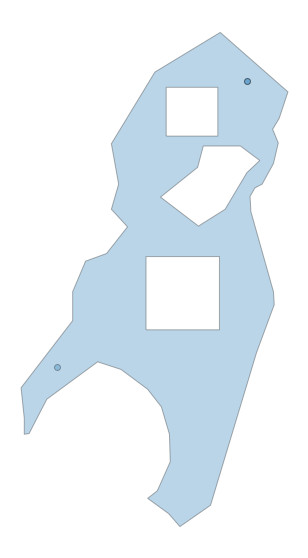

In [656]:
cside = 100 # coverage side in meters
cside = geopy.distance.distance(meters=cside)
shape_files = read_shapefile("sandbox/mapme_1.zip")
features = get_features_dict(shape_files)
final_coverage = get_final_coverage_polygon(features)
bounding_poly = get_bounding_poly(final_coverage)
bpoints = get_bounding_points(final_coverage)
w, h = get_hv_wh(final_coverage)
fgd_frame = create_gdframe(features)
fgd_frame.plot(figsize=(10,10),alpha=0.3,edgecolor='k')
plt.axis('off')

In [228]:
def get_square(ll, side):
    # returns the points of a square.
    points = [ll]
    points.append(side.destination(ll,0))
    points.append(side.destination(points[1],90))
    points.append(side.destination(ll,90))
    return points

In [252]:
def get_lat_lng(point):
    """
    From geopy points
    """
    return point.latitude, point.longitude

In [377]:
def get_grid_lines(side, final_coverage):
    """
    side : drone coverage square side
    final_coverage : coverage_area
    
    returns a Grid for the bounding box
    """
    markers = {
        "vertical":[],
        "horizontal":[]
    }
    
    P = lambda p: geopy.point.Point(p)
    ltlg = lambda p: (p.latitude, p.longitude)
    lglt = lambda p: (p.longitude, p.latitude)
    
    width, height = grid_size(side, final_coverage)
    side = geopy.distance.distance(meters=side)
    bpoints = get_bounding_points(final_coverage)
    
    ll = bpoints['ll']
    tl = ltlg((side*height).destination(P(ll),0))
#     tl = bpoints['tl']
    gline = shapely.geometry.LineString([ll[::-1],tl[::-1]])
    prev_pair = (P(ll),P(tl))
    markers['vertical'].append(ll)
    
    # Vertical lines
    for w in range(width):
        ll, tl = prev_pair
        nll = side.destination(ll,90)
        ntl = side.destination(tl,90)
        prev_pair = (nll,ntl)
        nll = lglt(nll)
        ntl = lglt(ntl)
        gline = gline.union(shapely.geometry.LineString([ntl,nll]))
        markers['vertical'].append(ltlg(nll))

    ll = bpoints['ll']
#     lr = bpoints['lr']
    lr = ltlg((side*width).destination(P(ll),90))
    gline = gline.union(shapely.geometry.LineString([ll[::-1],lr[::-1]]))
    prev_pair = (P(ll),P(lr))
    markers['vertical'].append(ll)

    # Horizontal lines
    for h in range(height):
        ll, lr = prev_pair
        nll = side.destination(ll,0)
        nlr = side.destination(lr,0)
        prev_pair = (nll,nlr)
        nll = lglt(nll)
        nlr = lglt(nlr)
        gline = gline.union(shapely.geometry.LineString([nll,nlr]))
    return gline

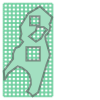

In [448]:
grid = get_grid_lines(500, final_coverage)
grid_intersec = grid.intersection(final_coverage)
grid.union(final_coverage)

In [538]:
def grid_points(side, coverage_area):
    # Taaha's funct
    """
    side : drone coverage square side
    """
    width, height = grid_size(side, coverage_area)
    side = geopy.distance.distance(meters=side)
    bpoints = get_bounding_points(coverage_area)
    

    latitudes = []
    start = geopy.Point(bpoints['ll'])
    for _ in range(height):
        latitudes.append(start)
        final = side.destination(point=start, bearing=0)
        start = final
    latitudes.append(start)
    
    longitudes = []
    start = geopy.Point(bpoints['ll'])
    for _ in range(width):
        longitudes.append(start)
        final = side.destination(point=start, bearing=90)
        start = final
    longitudes.append(start)
    
    return latitudes, longitudes, height, width

def matrix_lookup(side, coverage_area):
    # Taaha's funct
    """
    side : side of the drone in meters
    coverage_area : area to be covered by the drone
    """
    
    outside_map_traverse_area = coverage_area.envelope.difference(coverage_area)
    latitudes,longitudes,height,width = grid_points(side, coverage_area)
    lookup_c = np.zeros([height,width],dtype = 'O')
    raster = np.zeros([height, width],dtype = int)
    
    for x in range(len(latitudes)-1):
        for y in range(len(longitudes)-1):
            square = shapely.geometry.Polygon([(longitudes[y][1],latitudes[height-x][0]),\
                              (longitudes[y+1][1],latitudes[height-x][0]),\
                              (longitudes[y+1][1],latitudes[height-x-1][0]),\
                              (longitudes[y][1],latitudes[height-x-1][0])]) 
            lookup_c[x,y] = square.centroid
            # storing value of centre point
            if(outside_map_traverse_area.contains(square)):
                raster[x,y] = -1  # region outside the map but inside the gird
            if(square.intersects(coverage_area)):
                    z = square.intersection(coverage_area)
                    if(not z.is_empty):
                        if(coverage_area.contains(z)):
                            raster[x,y] = 0 #region inside the map
                        else:
                            raster[x,y] = 0 #2 is for boundary partial
                            #boundary_partial.append([x,y])

            for q in range(len(obstacles)):
                if(square.intersects(obstacles[q])):
                    z = square.intersection(obstacles[q])
                    if(not z.is_empty):
                        if(z.within(obstacles[q])):
                            raster[x,y] = -1    # inside the obstacle i.e fully covered
                        else:
                            if(not raster[x,y] == 2):  
                                raster[x,y] = -2 # partially covered obstacle
                                #a = obstacle_partial[q]
                                #a.append([x,y])
                elif(square.contains(obstacles[q])):
                    raster[x,y] = -2 # partially covered obstacle
    return raster

(233, 120)


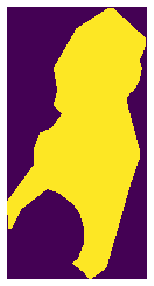

In [559]:
# inefficient, takes a lot of time
temp = matrix_lookup(50, features['coverage'][0])

print(temp.shape)
temp[0] = -1
temp[:,-1] = -1
imshow(temp)

In [560]:
def get_mask(poly, h, w):
    """
    Returns a boolean mask
    """
    y,x = np.mgrid[:h,:w] # Creates a mesh grid
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # stacks the meshgrids side by side
    mask = Path(poly).contains_points(coors).reshape(h,w)
    return mask

In [601]:
from fiona import transform

In [667]:
temp = fiona.open('./sandbox/layers/POLYGON.shp')
temp.crs

{'init': 'epsg:4326'}

In [673]:
fiona.listlayers("./sandbox/layers")

['POLYGON', 'POINT']

In [587]:
geo = [sh['geometry'] for sh in temp]

In [666]:
temp = transform.transform_geom("EPSG:3857","EPSG:5863", geo[0])

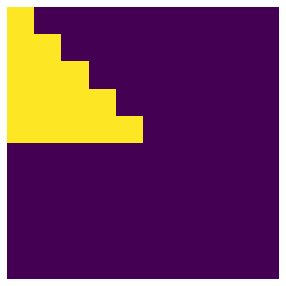

In [641]:
rows = cols = 10

geometry = {
    'type': 'Polygon',
    'coordinates': [[(0, 0), (0,5), (5, 5), (0,0)]]
}

imshow(rasterio.features.rasterize([geometry], (10,10)))

In [691]:
temp = fgd_frame.to_crs(epsg=4326)

In [754]:
w,h = get_hv_wh(final_coverage)
w = w.km
h = h.km

(2515, 1292)


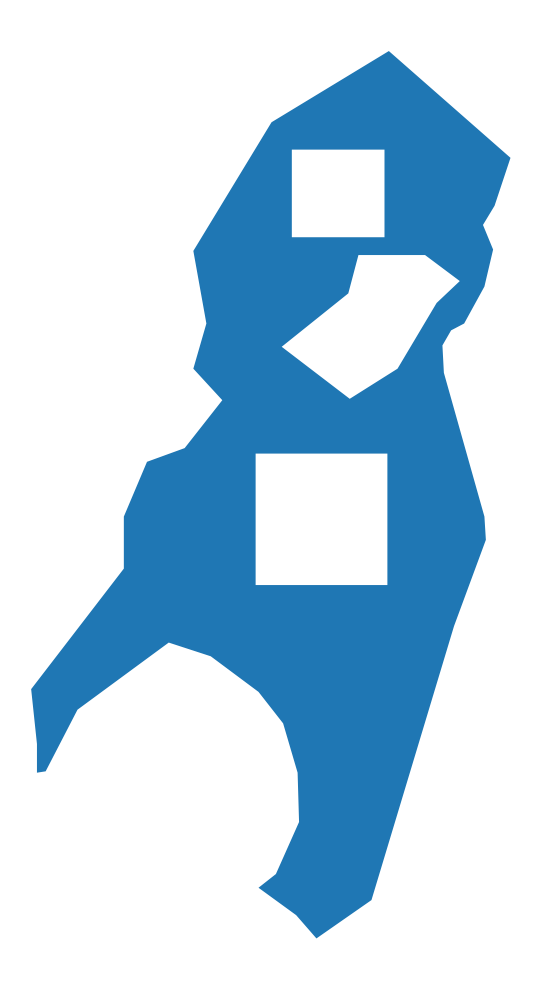

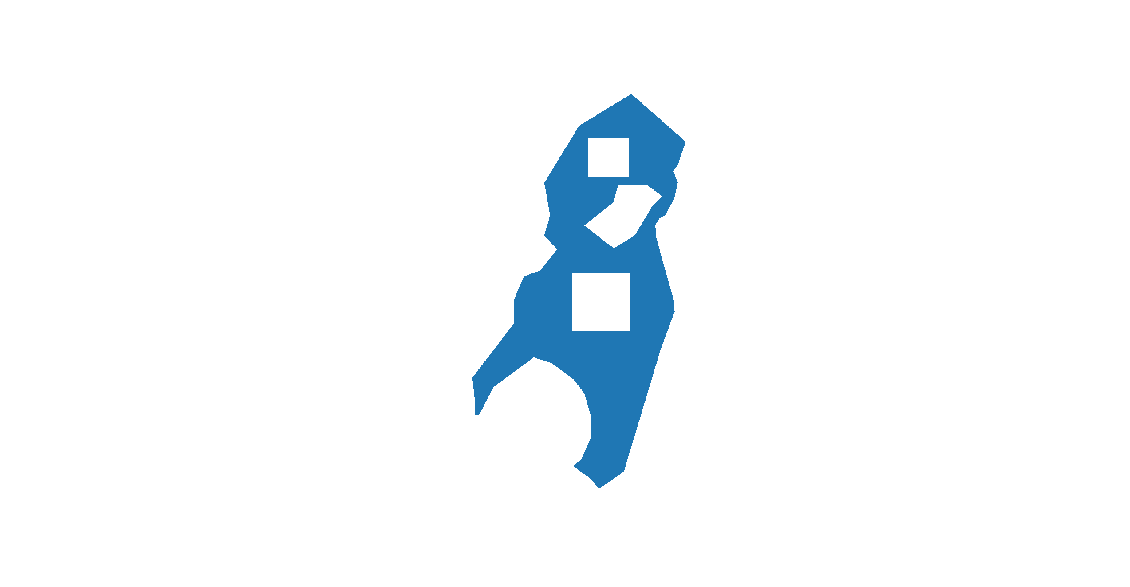

In [770]:
# fig = plt.figure(figsize=(20,20))
# fig.
f = temp.plot(figsize=(h*3,w*3))
plt.axis('off')
fig = f.figure
print(fig.canvas.get_width_height())

fig.canvas.draw()
# data = np.fromstring(f.figure.canvas.tostring_rgb(),dtype=np.uint8, sep='')
data = np.frombuffer(f.figure.canvas.tostring_rgb(),dtype=np.uint8)
sh = fig.canvas.get_width_height()
data = data.reshape(sh[::-1]+(3,))
imshow(data, figsize=(20,20))

In [627]:
rasterio.features.rasterize([geo[0]], (75,75),fill=-1,default_value=0).min()

-1

In [ ]:
"""
Divide haversine bounds by the width of the generated image to get cell widths and height and blah
"""